In [8]:
import tensorflow as tf

In [9]:
tf.config.list_physical_devices('GPU')

[]

In [84]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.applications.resnet import ResNet152
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from tensorflow import convert_to_tensor
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
dataset_path = "C:\\Users\\asimw\\Downloads\\Final exam dataset-20230107T074054Z-001\\Final exam dataset"

In [17]:
classes = os.listdir(dataset_path)
classes

['0-AK', '1-BCC', '2-BKL', '3-DF', '4-MEL', '5-NV', '6-SCC', '7-VASC']

Loading Data

In [18]:
#The image paths for all the classes
image_paths = []
#Respective labels for the images. Labels are not one hot encoded
labels = []
for folder in classes:
  folder_path = os.path.join(dataset_path, folder)
  img_paths = os.listdir(folder_path)
  image_paths = image_paths + [os.path.join(folder_path, img) for img in img_paths]
  labels = labels +  [classes.index(folder)] * len(img_paths)

In [19]:
len(image_paths), len(labels)

(1397, 1397)

In [20]:
IMAGE_WIDTH = 600
IMAGE_HEIGHT = 450

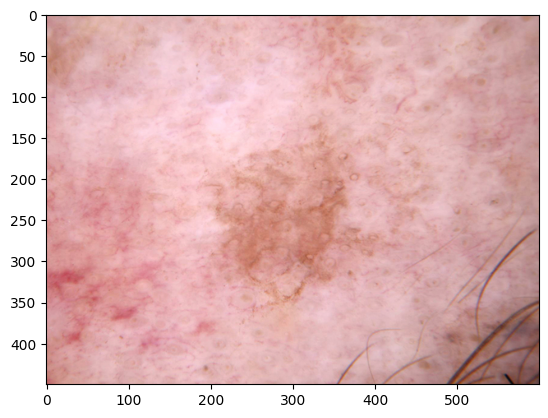

In [46]:
#Displaying an image
image = plt.imread(image_paths[10])
plt.imshow(image, cmap='gray')

In [22]:
#Image Dimensions
image.shape

(450, 600, 3)

Shuffling and Splitting Dataset to train and test

In [23]:
X, Y = shuffle(image_paths, labels, random_state = 402)
X = np.array(X)
Y = np.array(Y)

In [24]:
print(X.shape, Y.shape)

(1397,) (1397,)


In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 123, test_size = 0.2)

In [26]:
print(X_train.shape, Y_train.shape)

(1117,) (1117,)


In [27]:
print(X_test.shape, Y_test.shape)

(280,) (280,)


Creating Image Generator to Load Images while running

In [72]:
def generator(X, Y, epochs, steps_per_epoch, batch_size = 32):
  for j in range(epochs):
    for i in range(steps_per_epoch):
      indexes = np.random.choice(len(X), batch_size)
      x = []
      y = []
      for index in indexes:
        image = cv2.imread(X[index])
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        x.append(image)
        y.append(Y[index])
      x = convert_to_tensor(x, dtype='float32')
      y = convert_to_tensor(y, dtype = 'int32')
      yield (x, y)

# Model Building

In [64]:
loaded_model = ResNet152(include_top=False, weights = 'imagenet', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

In [65]:
for layer in loaded_model.layers:
  layer.trainable = False

In [78]:
x = Flatten()(loaded_model.output)
x = Dense(256, activation = 'sigmoid')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation = 'sigmoid')(x)
x = Dropout(0.2)(x)
x = Dense(len(classes), activation = 'softmax')(x)

model = Model(loaded_model.input, x)
model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [79]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 606, 456, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 300, 225, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

 conv2_block2_add (Add)         (None, 150, 113, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 150, 113, 25  0           ['conv2_block2_add[0][0]']       
                                6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 150, 113, 64  16448       ['conv2_block2_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 150, 113, 64  256        ['conv2_block3_1_conv[0][0]']    
 ization) 

 conv3_block2_3_conv (Conv2D)   (None, 75, 57, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 75, 57, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 75, 57, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 75, 57, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_blo

 conv3_block5_add (Add)         (None, 75, 57, 512)  0           ['conv3_block4_out[0][0]',       
                                                                  'conv3_block5_3_bn[0][0]']      
                                                                                                  
 conv3_block5_out (Activation)  (None, 75, 57, 512)  0           ['conv3_block5_add[0][0]']       
                                                                                                  
 conv3_block6_1_conv (Conv2D)   (None, 75, 57, 128)  65664       ['conv3_block5_out[0][0]']       
                                                                                                  
 conv3_block6_1_bn (BatchNormal  (None, 75, 57, 128)  512        ['conv3_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 38, 29, 256)  131328      ['conv3_block8_out[0][0]']       
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 38, 29, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 38, 29, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 38, 29, 256)  590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block3_add (Add)         (None, 38, 29, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, 38, 29, 1024  0           ['conv4_block3_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, 38, 29, 256)  262400      ['conv4_block3_out[0][0]']       
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 38, 29, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization) 

 ization)                       )                                                                 
                                                                                                  
 conv4_block6_add (Add)         (None, 38, 29, 1024  0           ['conv4_block5_out[0][0]',       
                                )                                 'conv4_block6_3_bn[0][0]']      
                                                                                                  
 conv4_block6_out (Activation)  (None, 38, 29, 1024  0           ['conv4_block6_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 38, 29, 256)  262400      ['conv4_block6_out[0][0]']       
                                                                                                  
 conv4_blo

 conv4_block9_3_bn (BatchNormal  (None, 38, 29, 1024  4096       ['conv4_block9_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block9_add (Add)         (None, 38, 29, 1024  0           ['conv4_block8_out[0][0]',       
                                )                                 'conv4_block9_3_bn[0][0]']      
                                                                                                  
 conv4_block9_out (Activation)  (None, 38, 29, 1024  0           ['conv4_block9_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block10_1_conv (Conv2D)  (None, 38, 29, 256)  262400      ['conv4_block9_out[0][0]']       
          

                                                                                                  
 conv4_block12_3_bn (BatchNorma  (None, 38, 29, 1024  4096       ['conv4_block12_3_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block12_add (Add)        (None, 38, 29, 1024  0           ['conv4_block11_out[0][0]',      
                                )                                 'conv4_block12_3_bn[0][0]']     
                                                                                                  
 conv4_block12_out (Activation)  (None, 38, 29, 1024  0          ['conv4_block12_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_blo

                                )                                                                 
                                                                                                  
 conv4_block15_3_bn (BatchNorma  (None, 38, 29, 1024  4096       ['conv4_block15_3_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block15_add (Add)        (None, 38, 29, 1024  0           ['conv4_block14_out[0][0]',      
                                )                                 'conv4_block15_3_bn[0][0]']     
                                                                                                  
 conv4_block15_out (Activation)  (None, 38, 29, 1024  0          ['conv4_block15_add[0][0]']      
                                )                                                                 
          

 conv4_block18_3_conv (Conv2D)  (None, 38, 29, 1024  263168      ['conv4_block18_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block18_3_bn (BatchNorma  (None, 38, 29, 1024  4096       ['conv4_block18_3_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block18_add (Add)        (None, 38, 29, 1024  0           ['conv4_block17_out[0][0]',      
                                )                                 'conv4_block18_3_bn[0][0]']     
                                                                                                  
 conv4_block18_out (Activation)  (None, 38, 29, 1024  0          ['conv4_block18_add[0][0]']      
          

                                                                                                  
 conv4_block21_3_conv (Conv2D)  (None, 38, 29, 1024  263168      ['conv4_block21_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block21_3_bn (BatchNorma  (None, 38, 29, 1024  4096       ['conv4_block21_3_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block21_add (Add)        (None, 38, 29, 1024  0           ['conv4_block20_out[0][0]',      
                                )                                 'conv4_block21_3_bn[0][0]']     
                                                                                                  
 conv4_blo

 on)                                                                                              
                                                                                                  
 conv4_block24_3_conv (Conv2D)  (None, 38, 29, 1024  263168      ['conv4_block24_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block24_3_bn (BatchNorma  (None, 38, 29, 1024  4096       ['conv4_block24_3_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block24_add (Add)        (None, 38, 29, 1024  0           ['conv4_block23_out[0][0]',      
                                )                                 'conv4_block24_3_bn[0][0]']     
          

 conv4_block27_2_relu (Activati  (None, 38, 29, 256)  0          ['conv4_block27_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block27_3_conv (Conv2D)  (None, 38, 29, 1024  263168      ['conv4_block27_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block27_3_bn (BatchNorma  (None, 38, 29, 1024  4096       ['conv4_block27_3_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block27_add (Add)        (None, 38, 29, 1024  0           ['conv4_block26_out[0][0]',      
          

                                                                                                  
 conv4_block30_2_relu (Activati  (None, 38, 29, 256)  0          ['conv4_block30_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block30_3_conv (Conv2D)  (None, 38, 29, 1024  263168      ['conv4_block30_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block30_3_bn (BatchNorma  (None, 38, 29, 1024  4096       ['conv4_block30_3_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_blo

 lization)                                                                                        
                                                                                                  
 conv4_block33_2_relu (Activati  (None, 38, 29, 256)  0          ['conv4_block33_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_3_conv (Conv2D)  (None, 38, 29, 1024  263168      ['conv4_block33_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block33_3_bn (BatchNorma  (None, 38, 29, 1024  4096       ['conv4_block33_3_conv[0][0]']   
 lization)                      )                                                                 
          

 conv4_block36_2_bn (BatchNorma  (None, 38, 29, 256)  1024       ['conv4_block36_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block36_2_relu (Activati  (None, 38, 29, 256)  0          ['conv4_block36_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block36_3_conv (Conv2D)  (None, 38, 29, 1024  263168      ['conv4_block36_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block36_3_bn (BatchNorma  (None, 38, 29, 1024  4096       ['conv4_block36_3_conv[0][0]']   
 lization)

 ization)                                                                                         
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, 19, 15, 512)  0          ['conv5_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, 19, 15, 512)  2359808     ['conv5_block3_1_relu[0][0]']    
                                                                                                  
 conv5_block3_2_bn (BatchNormal  (None, 19, 15, 512)  2048       ['conv5_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

In [68]:
from keras.preprocessing.image import ImageDataGenerator

In [69]:
#Basic Parameters
epochs = 5
batch_size = 32
steps_per_epoch = len(X_train) // batch_size

In [98]:
# train_gen = ImageDataGenerator(width_shift_range = 0.2, height_shift_range = 0.2)
# train_gen = train_gen.flow_from_directory(
#     dataset_path, 
#     target_size = (IMAGE_WIDTH, IMAGE_HEIGHT), 
#     batch_size = batch_size,
#     seed = 123)
# train_gen = tf.keras.utils.image_dataset_from_directory(
#   dataset_path,
#   validation_split=0.2,
#   subset='training',
#   seed=123,
#     color_mode='grayscale',
#   image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#   batch_size=batch_size)

validation_gen = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset='validation',
  seed=123,
  image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
  batch_size=batch_size)
train_gen = generator(X_train, Y_train, epochs, steps_per_epoch, batch_size)

Found 1397 files belonging to 8 classes.
Using 279 files for validation.


Training Model

In [74]:
(x, y)= next(train_gen)

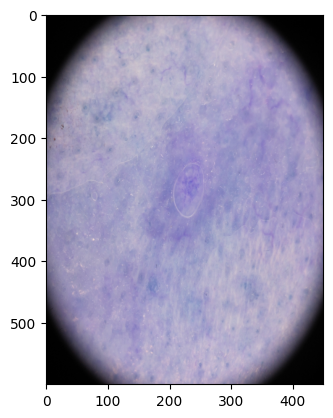

In [75]:
image = x[5] / 255.0
plt.imshow(image, cmap='gray')

In [96]:
history = model.fit(train_gen, epochs = epochs, steps_per_epoch = steps_per_epoch)

ValueError: Failed to find data adapter that can handle input: <class 'keras.preprocessing.image.ImageDataGenerator'>, <class 'NoneType'>

In [86]:
 history.history.keys()

dict_keys(['loss', 'accuracy'])

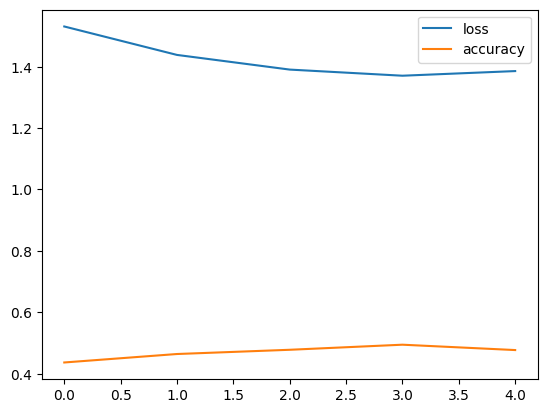

In [87]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.legend()
plt.show()

In [ ]:
model.save("Model1.h5")

In [94]:
y_pred = model.evaluate(validation_gen)

9/9 [==============================] - 212s 23s/step - loss: 1.3021 - accuracy: 0.5448


In [112]:
y_pred = model.predict(validation_gen)

9/9 [==============================] - 212s 23s/step


In [105]:
labels = []
for (x, y) in validation_gen:
    for j in y:
        labels.append(j)
labels = convert_to_tensor(labels)

In [113]:
y_preds = np.argmax(y_pred, axis = 1)
y_preds

array([5, 7, 0, 7, 5, 7, 7, 2, 4, 4, 2, 5, 7, 7, 7, 2, 5, 2, 5, 4, 7, 1,
       7, 7, 5, 0, 2, 5, 4, 1, 7, 5, 2, 0, 4, 0, 2, 4, 6, 2, 2, 6, 7, 1,
       7, 0, 2, 7, 7, 4, 0, 5, 6, 2, 5, 1, 4, 6, 2, 0, 7, 7, 2, 2, 2, 0,
       4, 0, 2, 5, 2, 0, 0, 7, 6, 1, 4, 5, 0, 0, 2, 0, 6, 5, 5, 2, 4, 7,
       0, 5, 0, 2, 5, 7, 0, 0, 0, 7, 2, 4, 0, 2, 4, 6, 4, 5, 2, 5, 5, 2,
       4, 0, 2, 4, 0, 7, 2, 2, 4, 4, 0, 4, 7, 4, 0, 6, 0, 2, 2, 7, 0, 7,
       2, 6, 7, 0, 1, 0, 2, 5, 7, 5, 5, 2, 7, 6, 7, 1, 2, 4, 2, 2, 2, 0,
       4, 6, 4, 5, 1, 7, 4, 0, 4, 6, 5, 2, 2, 2, 4, 5, 2, 7, 5, 0, 7, 6,
       7, 4, 4, 1, 4, 4, 4, 6, 4, 0, 0, 0, 7, 0, 2, 0, 7, 5, 5, 1, 0, 5,
       0, 2, 2, 4, 7, 4, 7, 7, 7, 7, 0, 1, 0, 5, 0, 0, 0, 5, 7, 4, 5, 2,
       7, 5, 7, 4, 2, 7, 1, 7, 0, 2, 0, 5, 7, 2, 4, 4, 1, 5, 5, 5, 4, 4,
       7, 6, 0, 1, 5, 6, 0, 4, 0, 4, 0, 6, 2, 2, 0, 1, 0, 7, 5, 2, 6, 7,
       2, 0, 4, 2, 0, 5, 7, 0, 7, 5, 1, 0, 1, 7, 0], dtype=int64)

In [118]:
cm = confusion_matrix(labels, y_preds)

In [119]:
cm

array([[ 6,  3,  5,  0,  9,  4,  1,  8],
       [ 8,  1,  6,  0,  6,  4,  3,  7],
       [ 8,  6, 10,  0,  6,  8,  6, 14],
       [ 3,  2,  4,  0,  3,  1,  1,  2],
       [11,  1,  7,  0,  3,  4,  2,  3],
       [ 6,  2,  8,  0,  7,  7,  1, 10],
       [ 7,  0,  8,  0,  7,  6,  4,  7],
       [ 7,  2,  4,  0,  2,  7,  0,  1]], dtype=int64)

In [120]:
import seaborn as sns

<AxesSubplot: >

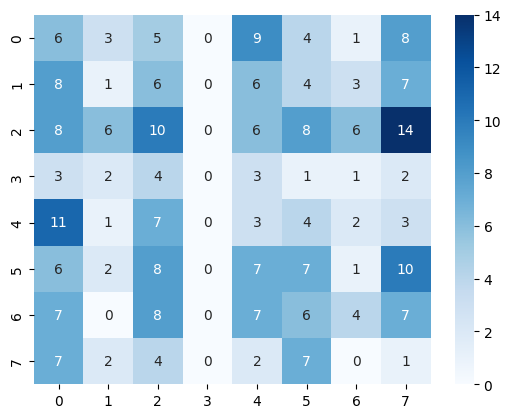

In [126]:
sns.heatmap(cm, annot=True, cmap='Blues')

In [127]:
model.save("Model2.h5")